In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)



def plot_embed_with_label(dfp, label_col = ['cancer_type'],  label_type = ['c'], orders = [None],
                          figsize=(10,10), metric='correlation',  
                          spread = 1, n_neighbors=5, min_dist = 0.5,  
                          s = 5,random_state = 123, verbose = False, return_coord = True,
                          cmap = 'bright', **kwargs):


    '''
    dfp: dataframe of samples x genes, with a column contains batch information
    label_col: list of labels to be used
    label_type: list of the label types, 'c' for categorical label, 'r' for continous label
    ''' 

    glist = dfp.columns[~dfp.columns.isin(label_col)]
    if len(glist) == 2:
        df2d = dfp[glist]
    else:
        mp = UMAP(spread=spread, min_dist=min_dist, n_neighbors=n_neighbors, 
                  metric=metric, random_state=random_state,
                  verbose=verbose,  **kwargs) #, metric='correlation'
        embed = mp.fit_transform(dfp[glist])
        df2d = pd.DataFrame(embed, columns=['UMAP1', 'UMAP2'],index=dfp.index)
    col1, col2 = df2d.columns
    df2d = df2d.join(dfp[label_col])
    
    figs = []
    for label, t, order in zip(label_col, label_type, orders):
        fig, ax = plt.subplots(figsize=figsize) 
        if t == 'c': 
            cohort_order =  order #df2d.groupby(label).size().sort_values().index
            if cohort_order is None:
                cohort_order = df2d.groupby(label).size().sort_values().index
            colors =  sns.color_palette(cmap, len(cohort_order)).as_hex()

            for bt, c in zip(cohort_order, colors):
                dfp1 = df2d[df2d[label] == bt]
                ax.scatter(dfp1[col1], dfp1[col2], label = bt, s = s,  c = c)
                #print(color)
            if len(cohort_order) <= 10:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                ax.legend(loc='center left', ncol=1, prop={'size':12},  bbox_to_anchor=(1, 0.5)) #
        else:
            ax.scatter(df2d[col1], df2d[col2], label = label, s = s, c = df2d[label], cmap = cmap)        
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
        ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        sns.despine(top=True, right=True, left=False, bottom=False)
        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
        ax.set_title(label)
        
        figs.append(fig)
    if not return_coord:
        return figs
    else:
        return figs, df2d

In [2]:
# load the pretrained model as a feature extractor
pretrainer = loadconceptor('../checkpoint/latest/pretrainer.pt')
#pretrainer = loadconceptor('../checkpoint/notask/bc_pretrainer.pt')

genesetprojector = pretrainer.model.latentprojector.genesetprojector
cellpathwayprojector = pretrainer.model.latentprojector.cellpathwayprojector
pretrainer.count_parameters()

1019894

In [3]:
sns.color_palette("tab20")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [4]:
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

## TCGA space, group by canncer

Before and After pretraining

In [5]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/15672/data'

In [6]:
cancer2plot = ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']

In [7]:
df_label = pd.read_pickle(os.path.join(data_path, 'TCGA.PATIENT.TABLE'))
df_label.cancer_type = df_label.cancer_type.apply(lambda x:x.replace('TCGA-', ''))
df_tpm = pd.read_pickle(os.path.join(data_path, 'TCGA.TPM.TABLE'))

df_label = df_label[df_label.cancer_type.isin(cancer2plot)]
df_tpm = df_tpm.loc[df_label.index]

df_tpm.shape, df_label.shape

((2935, 15672), (2935, 25))

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


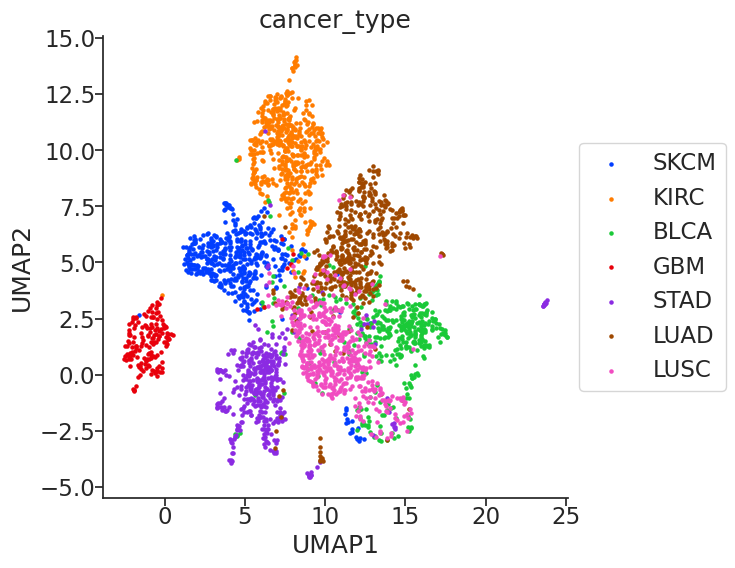

In [8]:
dfp = df_tpm.join(df_label.cancer_type)
figs = plot_embed_with_label(dfp,label_col=['cancer_type'], label_type=['c'], 
                             orders = [cancer2plot], figsize=(6, 6),verbose=False)
fig, df2d = figs
fig[0].savefig('cancer_tcga_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cancer_tcga_before_pretrain.csv')

100%|##########| 46/46 [00:21<00:00,  2.12it/s]
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


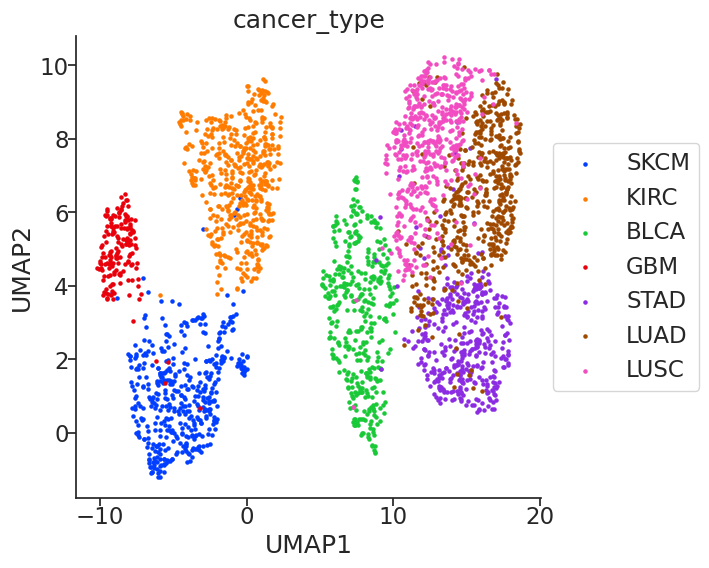

In [9]:
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame().join(df_tpm)
dfg, dfc = pretrainer.extract(dfcx, batch_size=64)
dfp1 = dfc[dfc.columns[:]].join(df_label.cancer_type)
figs1 = plot_embed_with_label(dfp1,label_col=['cancer_type'],label_type=['c'], #min_dist = 0.2,
                              orders = [cancer2plot], figsize=(6, 6), verbose=False)
fig1, df2d = figs1
fig1[0].savefig('cancer_tcga_after_pretrain.pdf',bbox_inches ='tight')
df2d.to_csv('cancer_tcga_after_pretrain.csv')

## ITRP space, group by cancer

Before and After pretraining

In [10]:
itrp_data_path = '../00_data/'

itrp_df_label = pd.read_pickle(os.path.join(itrp_data_path, 'ITRP.PATIENT.TABLE'))
itrp_df_tpm = pd.read_pickle(os.path.join(itrp_data_path, 'ITRP.TPM.TABLE'))
itrp_df_tpm = itrp_df_tpm[pretrainer.feature_name]

itrp_df_label.cohort = itrp_df_label.cancer_type +'_' + itrp_df_label.cohort.apply(lambda x:x.split('_')[0])
# cohort2plot = ['SKCM_Liu', 'SKCM_Gide', 'SKCM_Allen', 'SKCM_MGH', 'SKCM_Hugo',
#                'SKCM_Riaz', 'KIRC_Choueiri', 'KIRC_IMmotion150', 'KIRC_Miao',
#                'BLCA_IMVigor210', 'BLCA_Rose', 'BLCA_Snyder',
#                'GBM_Zhao', 'STAD_Kim',  'LUAD_Ravi']

# itrp_df_label = itrp_df_label[itrp_df_label.cohort.isin(cohort2plot)]
# itrp_df_tpm = itrp_df_tpm.loc[itrp_df_label.index]

In [11]:
itrp_df_label.cohort.unique()

array(['BLCA_IMVigor210', 'BLCA_Rose', 'BLCA_Snyder', 'GBM_Zhao',
       'KIRC_Choueiri', 'KIRC_IMmotion150', 'KIRC_Miao', 'LUAD_SU2CLC1',
       'LUSC_SU2CLC2', 'SKCM_Allen', 'SKCM_Gide', 'SKCM_Hugo', 'SKCM_Liu',
       'SKCM_MGH', 'SKCM_Riaz', 'STAD_Kim'], dtype=object)

In [12]:
itrp_df_label.columns

Index(['Sample_id', 'response_label', 'RECIST', 'Timing', 'cohort',
       'cancer_type', 'sequencer', 'ICI', 'ICI_target', 'Tissue',
       ...
       'BR', 'RECIST_Response', 'Mutational Subtype', 'participant',
       'ICI_target_map', 'ICI_map', 'Biopsy_site', 'sub_cohort',
       'sub_cohort_used_flag', 'real_TMB'],
      dtype='object', length=110)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


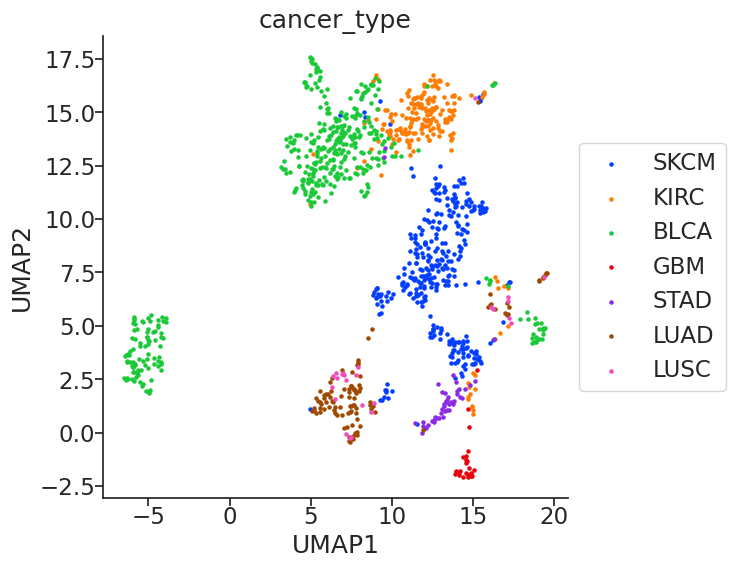

In [13]:
dfp = itrp_df_tpm.join(itrp_df_label.cancer_type)
figs = plot_embed_with_label(dfp,label_col=['cancer_type'],label_type=['c'], orders = [cancer2plot], figsize=(6, 6), verbose=False)
fig, df2d = figs
fig[0].savefig('cancer_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cancer_itrp_before_pretrain.csv')

100%|##########| 9/9 [00:08<00:00,  1.08it/s]
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


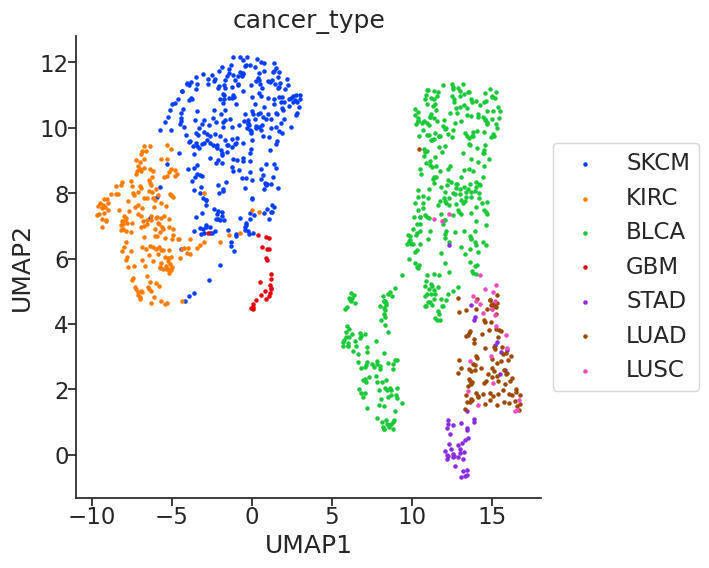

In [15]:
dfcx = itrp_df_label.cancer_type.map(CANCER_CODE).to_frame().join(itrp_df_tpm)
dfg, dfc = pretrainer.extract(dfcx, batch_size=128)
dfp1 = dfc[dfc.columns[:]].join(itrp_df_label.cancer_type)
figs1 = plot_embed_with_label(dfp1,label_col=['cancer_type'],label_type=['c'], orders = [cancer2plot], figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('cancer_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cancer_itrp_after_pretrain.csv')

## ITRP space, group by Target

Before and After pretraining

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


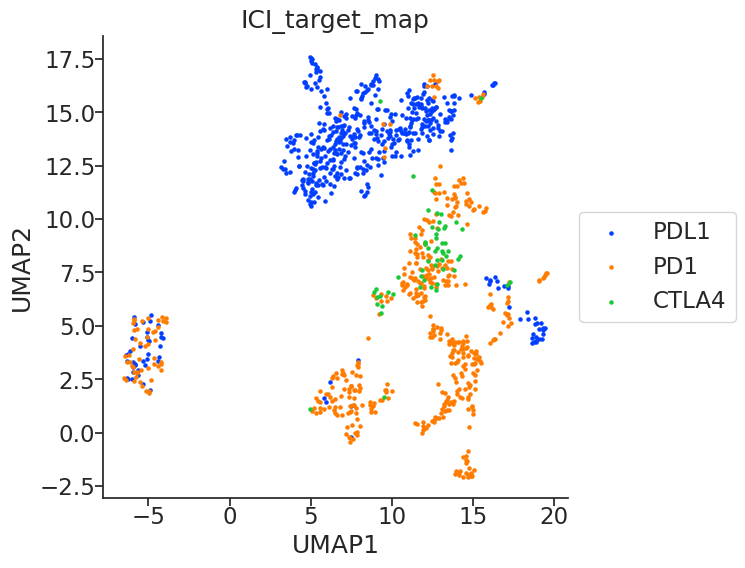

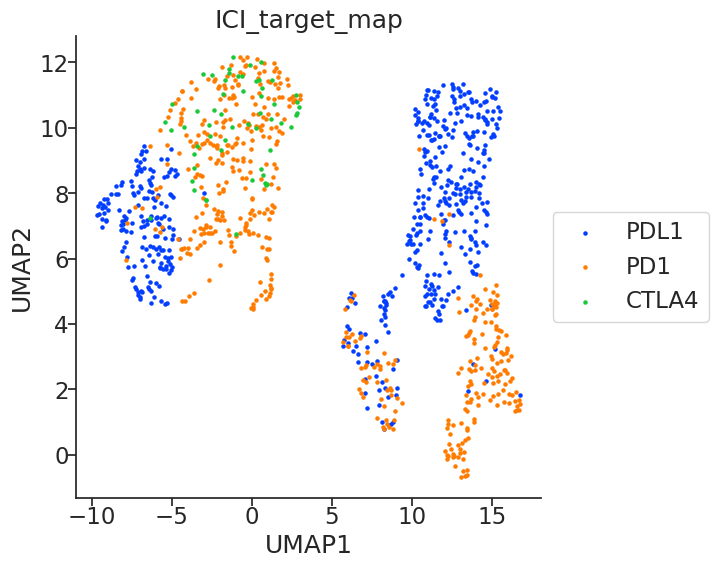

In [17]:
ici_target_order = ['PDL1', 'PD1', 'CTLA4', ]#'PD1 + CTLA4'
dfp1 = itrp_df_tpm.join(itrp_df_label['ICI_target_map'])
figs1 = plot_embed_with_label(dfp1,label_col=['ICI_target_map'],label_type=['c'], orders = [ici_target_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('target_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('target_itrp_before_pretrain.csv')

dfp1 = dfc[dfc.columns[:]].join(itrp_df_label['ICI_target_map'])
figs1 = plot_embed_with_label(dfp1,label_col=['ICI_target_map'],label_type=['c'], orders = [ici_target_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('target_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('target_itrp_after_pretrain.csv')


## ITRP space, group by Drug

Before and After pretraining

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


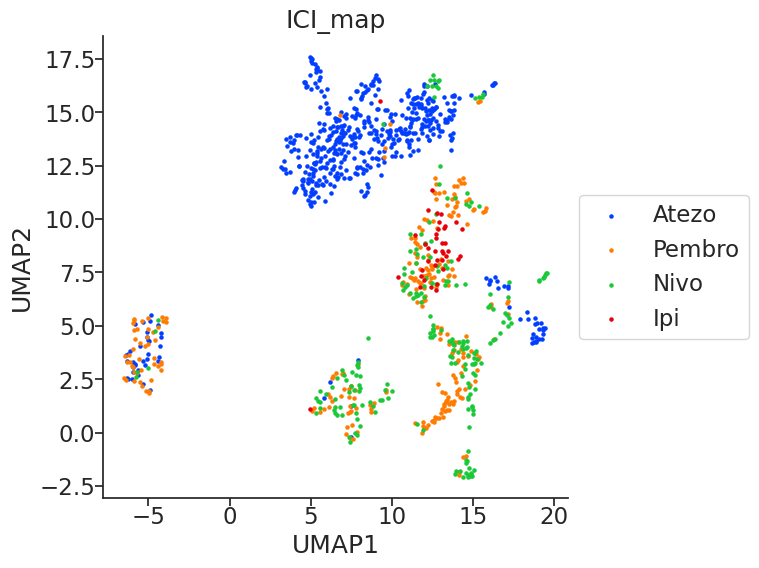

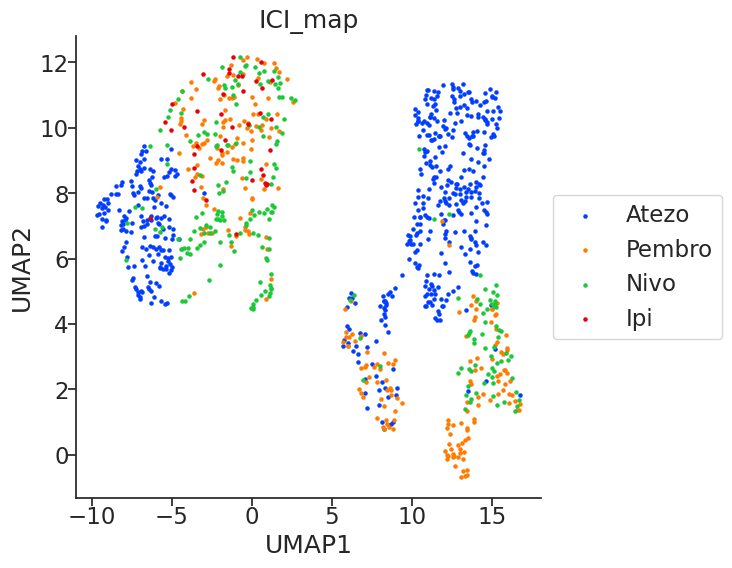

In [18]:
ici_order = ['Atezo','Pembro', 'Nivo', 'Ipi']

dfp1 = itrp_df_tpm.join(itrp_df_label['ICI_map'])
figs1 = plot_embed_with_label(dfp1,label_col=['ICI_map'],label_type=['c'], orders = [ici_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('drug_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('drug_itrp_before_pretrain.csv')


dfp1 = dfc[dfc.columns[:]].join(itrp_df_label['ICI_map'])
figs1 = plot_embed_with_label(dfp1,label_col=['ICI_map'],label_type=['c'], orders = [ici_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('drug_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('drug_itrp_after_pretrain.csv')

# ITRP space, group by Sequencer
Before and After pretraining

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


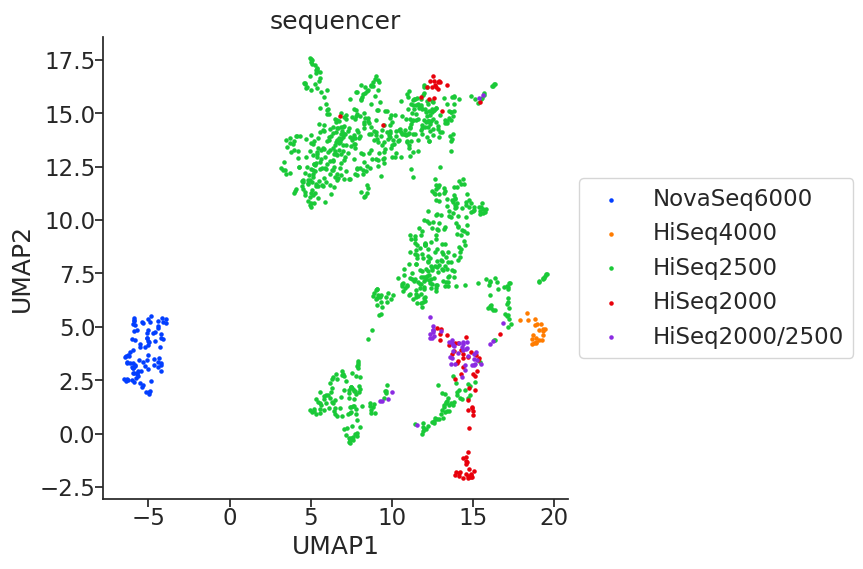

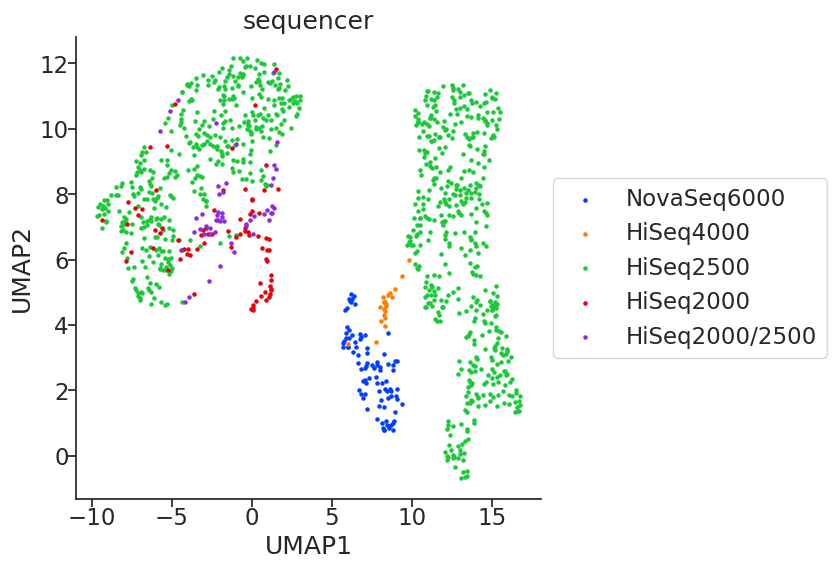

In [19]:
sequencer_order = ['NovaSeq6000', 'HiSeq4000', 'HiSeq2500', 'HiSeq2000', 'HiSeq2000/2500']
dfp1 = itrp_df_tpm.join(itrp_df_label['sequencer'])
figs1 = plot_embed_with_label(dfp1,label_col=['sequencer'],label_type=['c'], orders = [sequencer_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('sequencer_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('sequencer_itrp_before_pretrain.csv')

sequencer_order = ['NovaSeq6000', 'HiSeq4000', 'HiSeq2500', 'HiSeq2000', 'HiSeq2000/2500']
dfp1 = dfc[dfc.columns[:]].join(itrp_df_label['sequencer'])
figs1 = plot_embed_with_label(dfp1,label_col=['sequencer'],label_type=['c'], orders = [sequencer_order],  figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('sequencer_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('sequencer_itrp_after_pretrain.csv')

In [20]:
cohort2plot = ['LUSC_SU2CLC2',
 'LUAD_SU2CLC1',
 'KIRC_IMmotion150',
 'KIRC_Choueiri',
 'KIRC_Miao',
 'BLCA_Rose',
 'BLCA_IMVigor210',
 'BLCA_Snyder',
 'GBM_Zhao',
 'SKCM_Hugo',
 'SKCM_Riaz',
 'SKCM_Gide',
 'SKCM_MGH',
 'SKCM_Liu',
 'SKCM_Allen',
 'STAD_Kim']

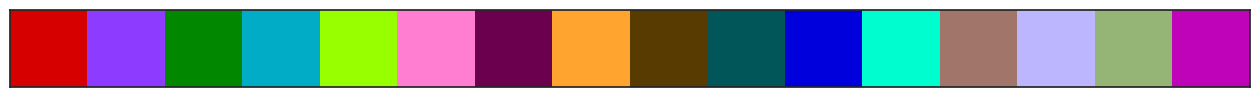

In [21]:
import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors= len(cohort2plot))
sns.palplot(palette)

In [23]:
dfpa = pd.DataFrame(list(palette))
from sklearn.decomposition import PCA
from umap import UMAP
mp = UMAP(n_components=1, n_neighbors=5)
d1 = mp.fit_transform(dfpa)
idx = pd.Series(d1.reshape(-1,)).sort_values().index


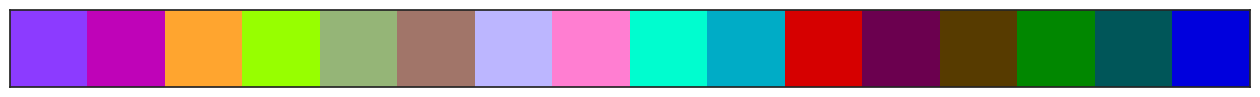

In [24]:
dfpa = dfpa.iloc[idx]
palette = dfpa.values.tolist()
sns.palplot(palette)

## ITRP space, group by cohort

Before and After pretraining

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


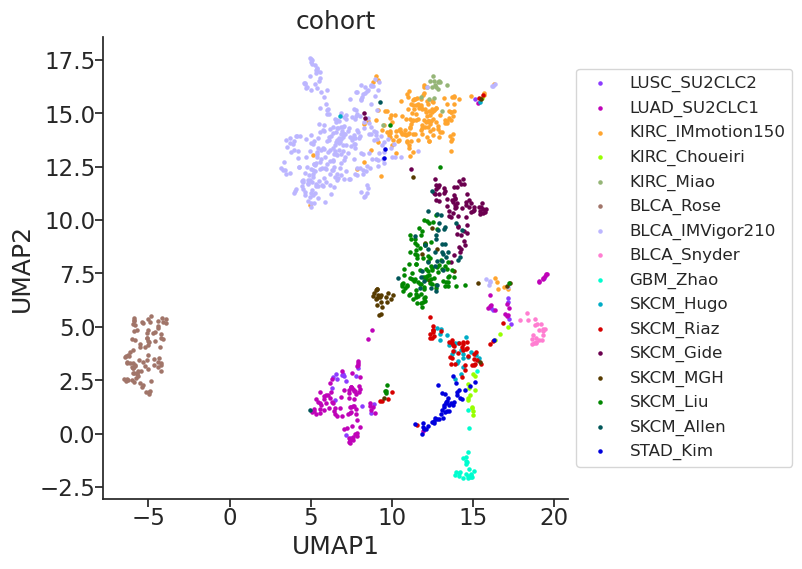

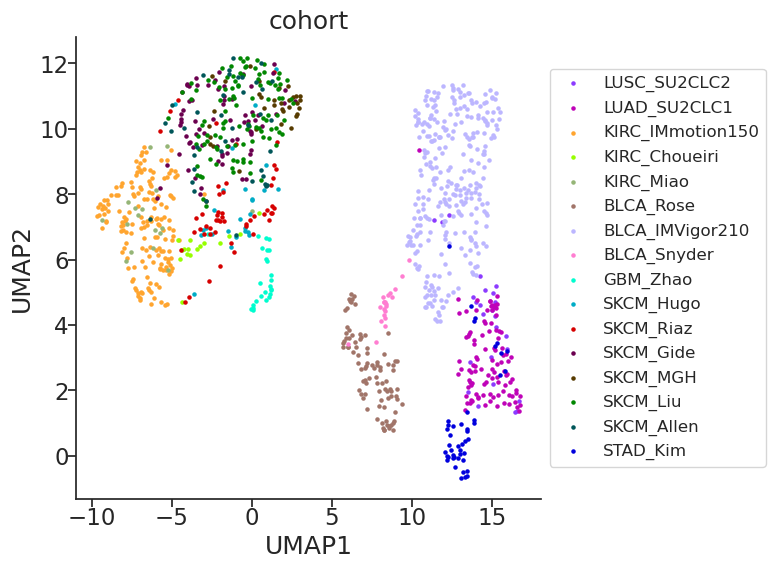

In [25]:
dfp0 = itrp_df_tpm.join(itrp_df_label.cohort)
figs1 = plot_embed_with_label(dfp0,label_col=['cohort'],label_type=['c'], cmap = palette,
                              orders = [cohort2plot], figsize=(6, 6), verbose=False)
fig1, df2d = figs1
fig1[0].savefig('cohort_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cohort_itrp_before_pretrain.csv')

dfp1 = dfc[dfc.columns[:]].join(itrp_df_label.cohort)
figs1 = plot_embed_with_label(dfp1,label_col=['cohort'],label_type=['c'], cmap = palette,
                              orders = [cohort2plot], figsize=(6, 6), verbose=False)
fig1, df2d = figs1
fig1[0].savefig('cohort_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cohort_itrp_after_pretrain.csv')